In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from models import KeyPointVAE
from utils.util_func import reparameterize
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import argparse

#from accelerate import Accelerator, DistributedDataParallelKwargs
from utils.util_func import plot_bb_on_image_batch_from_masks, plot_bb_on_image_batch_from_masks_nms, plot_keypoints_on_image, plot_keypoints_on_image_batch, plot_bb_on_image_from_masks, plot_bb_on_image_from_masks_nms
from utils.util_func import create_masks_fast
from datasets.calvin_dataset import CalvinDataset

decoder backbone: gauss_pointnetpp
prior std: 0.1
keypoints range: (-1, 1)
total number of kp: 64 -> prior kp: 20
number of kp from encoder: 10
kp_activation: tanh
learnable feature dim: 10
mask threshold: 0.2
object patch size: 32
object encoder: True, object decoder: True
learn particles order: False
conv shape:  torch.Size([256, 16, 16])
conv shape:  torch.Size([32, 8, 8])
conv shape:  torch.Size([64, 4, 4])
YES
loaded model from checkpoint
dict_keys(['kp_p', 'gmap', 'rec', 'mu', 'logvar', 'mu_features', 'logvar_features', 'cropped_objects_original', 'cropped_objects_masks', 'obj_on', 'dec_objects_original', 'dec_objects', 'order_weights'])
tensor([[[ 0.6838, -0.3504],
         [-0.5341, -0.4017],
         [-0.5574, -0.4072],
         [-0.7486,  0.6006],
         [-0.4706, -0.6212],
         [-0.1544, -0.7241],
         [ 0.0548,  0.1856],
         [-0.2919, -0.1185],
         [-0.2730,  0.1796],
         [-0.0285, -0.0307],
         [ 0.0000,  0.0000]]], device='cuda:0')
tensor([[[

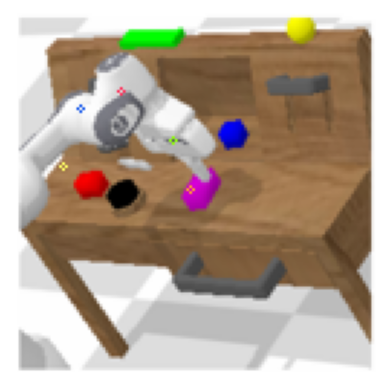

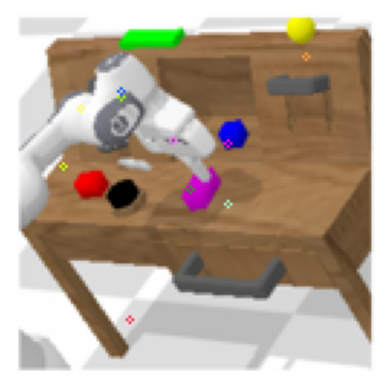

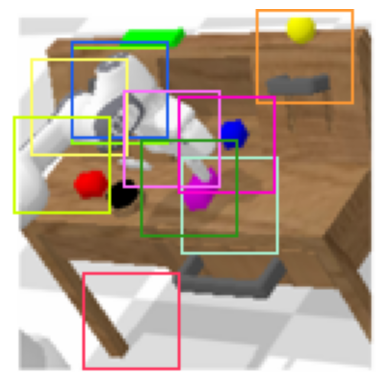

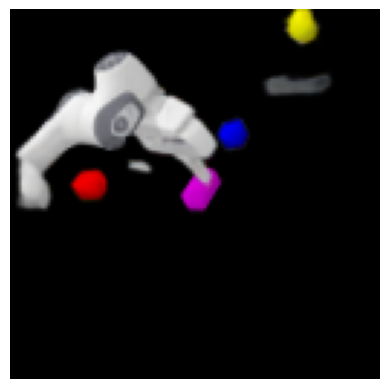

In [2]:


image_idx = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_logsoftmax = False
pad_mode = 'replicate'
sigma = 0.1
dropout = 0.0
n_kp = 1
kp_range = (-1, 1)
kp_activation = "tanh"
mask_threshold = 0.2
learn_order = False
path_to_model_ckpt = './checkpoints/calvin_dlp_gauss_pointnetpp_best.pth'
image_size = 128
ch = 3
enc_channels = [32, 64, 128, 256]
prior_channels = (16, 32, 64)
imwidth = 160
crop = 16
n_kp_enc = 10 
n_kp_prior = 20 
use_object_enc = True
use_object_dec = True
learned_feature_dim = 10
patch_size = 16
anchor_s = 0.25
dec_bone = "gauss_pointnetpp"
exclusive_patches = False

model = KeyPointVAE(cdim=ch, enc_channels=enc_channels, prior_channels=prior_channels,
                    image_size=image_size, n_kp=n_kp, learned_feature_dim=learned_feature_dim,
                    use_logsoftmax=use_logsoftmax, pad_mode=pad_mode, sigma=sigma,
                    dropout=dropout, dec_bone=dec_bone, patch_size=patch_size, n_kp_enc=n_kp_enc,
                    n_kp_prior=n_kp_prior, kp_range=kp_range, kp_activation=kp_activation,
                    mask_threshold=mask_threshold, use_object_enc=use_object_enc,
                    exclusive_patches=exclusive_patches, use_object_dec=use_object_dec, anchor_s=anchor_s,
                    learn_order=learn_order).to(device)

model.load_state_dict(torch.load(path_to_model_ckpt, map_location=device), strict=False)
model.eval()
print("loaded model from checkpoint")

path_to_images = ['./checkpoints/sample_images/calvin/calvin_scene_A.png',
                          './checkpoints/sample_images/calvin/calvin_scene_B.png',
                          './checkpoints/sample_images/calvin/calvin_scene_C.png',
                          './checkpoints/sample_images/calvin/calvin_scene_D.png',
                          './checkpoints/sample_images/calvin/calvin_scene_D_2.png',
                          './checkpoints/sample_images/calvin/calvin_scene_D_3.png',
                          './checkpoints/sample_images/calvin/calvin_scene_D_4.png']

image_idx = min(image_idx, len(path_to_images) - 1)
path_to_image = path_to_images[image_idx]
im = Image.open(path_to_image)
im = im.convert('RGB')
im = im.resize((image_size, image_size), Image.BICUBIC)
trans = transforms.ToTensor()
data = trans(im)
data = data.unsqueeze(0).to(device)
x = data
logvar_threshold = 13.0

with torch.no_grad():
        deterministic = True

        model_output = model(x, x_prior=x)
        mu_p = model_output['kp_p']
        gmap = model_output['gmap']
        mu = model_output['mu']
        logvar = model_output['logvar']
        rec_x = model_output['rec']
        mu_features = model_output['mu_features']
        logvar_features = model_output['logvar_features']
        # object stuff
        dec_objects_original = model_output['dec_objects_original']
        cropped_objects_original = model_output['cropped_objects_original']
        print(model_output.keys())
        print(mu)
        print(rec_x)
        print(mu_p)
        print(mu_features)
        print(logvar_features)
        '''
        enc_out = model.encode_all(data, return_heatmap=True, deterministic=deterministic)
        mu, logvar, kp_heatmap, mu_features, logvar_features, obj_on, order_weights = enc_out
        '''
        if deterministic:
            z = mu
            z_features = mu_features
        else:
            z = reparameterize(mu, logvar)
            z_features = reparameterize(mu_features, logvar_features)
        # top-k
        logvar_sum = logvar.sum(-1)
        logvar_topk = torch.topk(logvar_sum, k=5, dim=-1, largest=False)
        indices = logvar_topk[1]  # [batch_size, topk]
        batch_indices = torch.arange(mu.shape[0]).view(-1, 1).to(mu.device)
        topk_kp = mu[batch_indices, indices]
        # bounding boxes
        masks = create_masks_fast(mu[:, :-1].detach(), anchor_s=model.anchor_s, feature_dim=x.shape[-1])
        masks = torch.where(masks < mask_threshold, 0.0, 1.0)
        bb_scores = -1 * logvar_sum
        hard_threshold = bb_scores.mean()

        # print(masks[0].shape)
        # print(masks[0])
        # print(x[0].shape)
        # print(bb_scores[0].shape)
        # print(bb_scores[0])
        # img_with_masks_nms = plot_bb_on_image_from_masks_nms(masks[0], x[0], scores=bb_scores[0])
        img_with_masks = plot_bb_on_image_from_masks(masks[0], x[0])
        #img_with_masks_nms, nms_ind = plot_bb_on_image_batch_from_masks_nms(masks, x,scores=bb_scores)
N = mu.shape[1]
xmin = 0
xmax = image_size

x = np.linspace(xmin, xmax, N)

mu = mu.clamp(kp_range[0], kp_range[1])
original_mu = mu.clone()
mu = (mu - kp_range[0]) / (kp_range[1] - kp_range[0])
xvals = mu[0, :-1, 1].data.cpu().numpy() * (image_size - 1)
yvals = mu[0, :-1, 0].data.cpu().numpy() * (image_size - 1)
if learned_feature_dim > 0:
    feature_1_vals = mu_features[0, :, -1].data.cpu().numpy()
    # set up a plot for topk

topk_kp = topk_kp.clamp(kp_range[0], kp_range[1])
topk_kp = (topk_kp - kp_range[0]) / (kp_range[1] - kp_range[0])
xvals_topk = topk_kp[0, :, 1].data.cpu().numpy() * (image_size - 1)
yvals_topk = topk_kp[0, :, 0].data.cpu().numpy() * (image_size - 1)


#print(topk_kp)
#print(data.shape)
#img_with_kp_topk = plot_keypoints_on_image_batch(topk_kp, data)
img_with_kp_topk = plot_keypoints_on_image(topk_kp[0], data[0])
plt.imshow(img_with_kp_topk)
plt.axis('off') 
plt.show()

img_with_kp = plot_keypoints_on_image(mu[:, :-1][0].clamp(min=kp_range[0], max=kp_range[1]), data[0])
plt.imshow(img_with_kp)
plt.axis('off') 
plt.show()

'''
img_with_kp_p = plot_keypoints_on_image(mu_p[0], data[0])
plt.imshow(img_with_kp_p)
plt.axis('off') 
plt.show()
'''

plt.imshow(img_with_masks)
plt.axis('off')
plt.show()

dec_objects = model_output['dec_objects']
plt.imshow(dec_objects[0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
# dec_objects[:max_imgs, -3:]

show image with kps

In [255]:

def showImgWithKP(img, model):
    model.eval()

    im = img
    im = im.convert('RGB')
    im = im.resize((image_size, image_size), Image.BICUBIC)
    trans = transforms.ToTensor()
    data = trans(im)
    data = data.unsqueeze(0).to(device)

    with torch.no_grad():
            model_output = model(data, x_prior=data)

            mu_p = model_output['kp_p']
            gmap = model_output['gmap']
            mu = model_output['mu']
            logvar = model_output['logvar']
            rec_x = model_output['rec']
            mu_features = model_output['mu_features']
            logvar_features = model_output['logvar_features']

            #print('kp_p: ', mu_p)
            # print('mu: ', mu)
            # print('mu_features: ', mu_features)
            #print('logvar: ', logvar)
            #print('logvar_features: ', logvar_features)
            #print('rec: ', rec_x)

            # top-k
            logvar_sum = logvar.sum(-1)
            logvar_topk = torch.topk(logvar_sum, k=10, dim=-1, largest=False)
            indices = logvar_topk[1]  # [batch_size, topk]
            batch_indices = torch.arange(mu.shape[0]).view(-1, 1).to(mu.device)
            topk_kp = mu[batch_indices, indices]


    topk_kp = topk_kp.clamp(kp_range[0], kp_range[1])
    topk_kp = (topk_kp - kp_range[0]) / (kp_range[1] - kp_range[0])

    img_with_kp_topk = plot_keypoints_on_image(topk_kp[0], data[0])

    dec_objects = model_output['dec_objects']
    dec_objects = dec_objects[0].permute(1, 2, 0).cpu().numpy()

    combined_img = np.hstack((img_with_kp_topk / 255.0, dec_objects))

    plt.imshow(combined_img)
    plt.axis('off') 
    plt.show()

def assosiateKP(img1, img2, model):
    model.eval()

    img1 = img1.convert('RGB')
    img1 = img1.resize((image_size, image_size), Image.BICUBIC)
    trans = transforms.ToTensor()
    data1 = trans(img1)
    data1 = data1.unsqueeze(0).to(device)

    img2 = img2.convert('RGB')
    img2 = img2.resize((image_size, image_size), Image.BICUBIC)
    trans = transforms.ToTensor()
    data2 = trans(img2)
    data2 = data2.unsqueeze(0).to(device)

    with torch.no_grad():
        model_output_1 = model(data1, x_prior=data1)
        model_output_2 = model(data2, x_prior=data2)

        mu_coords_1 = model_output_1['mu']
        mu_coords_2 = model_output_2['mu']
        mu_features_1 = model_output_1['mu_features']
        mu_features_2 = model_output_2['mu_features']
        logvar_1 = model_output_1['logvar']
        logvar_2 = model_output_2['logvar']

       # mu_1 = list(zip(mu_coords_1[0], mu_features_1[0]))
       # mu_2 = list(zip(mu_coords_2[0], mu_features_2[0]))
        mu_1 = list(zip(mu_coords_1[0].cpu().numpy(), mu_features_1[0].cpu().numpy()))
        mu_2 = list(zip(mu_coords_2[0].cpu().numpy(), mu_features_2[0].cpu().numpy()))

        matched_KPs = []
        for kp_1, feature_1 in mu_1:
            best_match = None
            best_sim = float('inf')
            for kp_2, feature_2 in mu_2:
                # Euclidean distance 
                geometric_sim = np.linalg.norm(kp_1 - kp_2)
                # Cosine Similarity
                cos_sim = np.dot(feature_1, feature_2) / ((np.linalg.norm(feature_1)) * (np.linalg.norm(feature_2)))
                semantic_sim = abs(1 - cos_sim)

                total_sim = geometric_sim + semantic_sim

                if total_sim < best_sim:
                    best_sim = total_sim
                    best_match = kp_2

                # print('simulatiry: ', total_sim, ' : ', geometric_sim, ' : ', semantic_sim)
            sim_threshold = 0.15
            if best_sim < sim_threshold:
                matched_KPs.append((kp_1, best_match, best_sim))

        # filter keypoints one-to-one
        matched_KPs.sort(key=lambda x: x[2])
        matched_KPs_filtered = []
        matched_kp_1 = []
        matched_kp_2 = []
        for kp_1, kp_2, sim in matched_KPs:
            if (kp_1[0], kp_1[1]) not in matched_kp_1 and (kp_2[0], kp_2[1]) not in matched_kp_2: 
                matched_KPs_filtered.append((kp_1, kp_2, sim))
                matched_kp_1.append((kp_1[0], kp_1[1]))
                matched_kp_2.append((kp_2[0], kp_2[1]))

        print(matched_KPs_filtered)


    kp_1_list = []
    kp_2_list = []
    for kp_1, kp_2, sim in matched_KPs_filtered:
        kp_1_list.append(kp_1)
        kp_2_list.append(kp_2)

        topk_kp_1 = torch.tensor([kp_1]).clamp(kp_range[0], kp_range[1])
        topk_kp_1 = (topk_kp_1 - kp_range[0]) / (kp_range[1] - kp_range[0])
        img_with_kp_topk_1 = plot_keypoints_on_image(topk_kp_1, data1[0])

        topk_kp_2 = torch.tensor([kp_2]).clamp(kp_range[0], kp_range[1])
        topk_kp_2 = (topk_kp_2 - kp_range[0]) / (kp_range[1] - kp_range[0])   
        img_with_kp_topk_2 = plot_keypoints_on_image(topk_kp_2, data2[0])

        combined_img = np.hstack((img_with_kp_topk_1,  img_with_kp_topk_2))

        plt.imshow(combined_img)
        plt.axis('off') 
        plt.show()  

'''
    topk_kp_1 = torch.tensor(kp_1_list).clamp(kp_range[0], kp_range[1])
    topk_kp_1 = (topk_kp_1 - kp_range[0]) / (kp_range[1] - kp_range[0])
    img_with_kp_topk = plot_keypoints_on_image(topk_kp_1, data1[0])
    plt.imshow(img_with_kp_topk)
    plt.axis('off') 
    plt.show()

    topk_kp_2 = torch.tensor(kp_2_list).clamp(kp_range[0], kp_range[1])
    topk_kp_2 = (topk_kp_2 - kp_range[0]) / (kp_range[1] - kp_range[0])   
    img_with_kp_topk = plot_keypoints_on_image(topk_kp_2, data2[0])
    plt.imshow(img_with_kp_topk)
    plt.axis('off') 
    plt.show()  
'''


"\n    topk_kp_1 = torch.tensor(kp_1_list).clamp(kp_range[0], kp_range[1])\n    topk_kp_1 = (topk_kp_1 - kp_range[0]) / (kp_range[1] - kp_range[0])\n    img_with_kp_topk = plot_keypoints_on_image(topk_kp_1, data1[0])\n    plt.imshow(img_with_kp_topk)\n    plt.axis('off') \n    plt.show()\n\n    topk_kp_2 = torch.tensor(kp_2_list).clamp(kp_range[0], kp_range[1])\n    topk_kp_2 = (topk_kp_2 - kp_range[0]) / (kp_range[1] - kp_range[0])   \n    img_with_kp_topk = plot_keypoints_on_image(topk_kp_2, data2[0])\n    plt.imshow(img_with_kp_topk)\n    plt.axis('off') \n    plt.show()  \n"

### Print keypoints for caption

decoder backbone: gauss_pointnetpp
prior std: 0.1
keypoints range: (-1, 1)
total number of kp: 64 -> prior kp: 20
number of kp from encoder: 10
kp_activation: tanh
learnable feature dim: 10
mask threshold: 0.2
object patch size: 32
object encoder: True, object decoder: True
learn particles order: False
conv shape:  torch.Size([256, 16, 16])
conv shape:  torch.Size([32, 8, 8])
conv shape:  torch.Size([64, 4, 4])
YES
loaded model from checkpoint
[(array([0., 0.], dtype=float32), array([0., 0.], dtype=float32), 5.227327346801758e-05), (array([-0.7522572,  0.6031692], dtype=float32), array([-0.74644315,  0.59843564], dtype=float32), 0.009381202980875969), (array([ 0.76707363, -0.39286906], dtype=float32), array([ 0.7720303 , -0.40029147], dtype=float32), 0.013557344675064087), (array([0.49391806, 0.20869474], dtype=float32), array([0.48927975, 0.18980439], dtype=float32), 0.033947428688406944)]


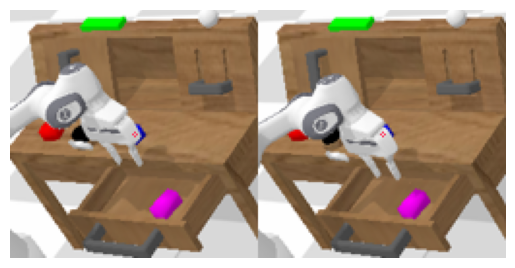

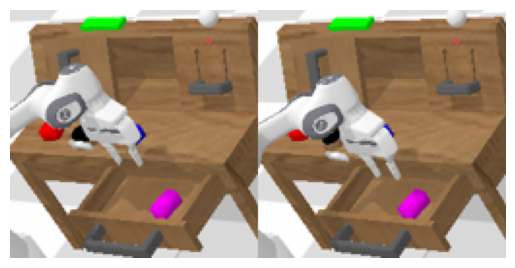

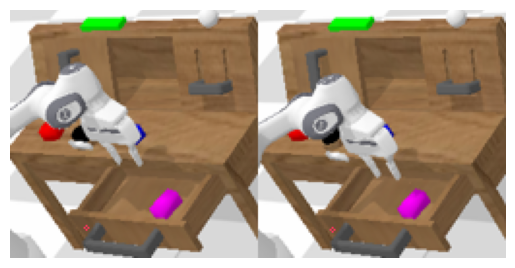

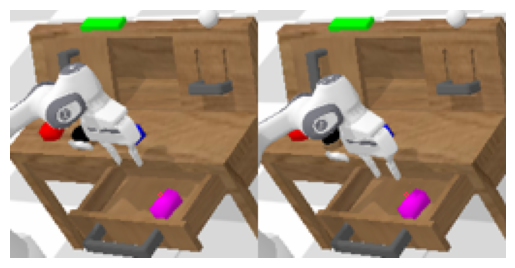

In [256]:
from PIL import Image
import numpy as np

def getIndex(path, ann):
        annotations = np.load('{}/lang_annotations/auto_lang_ann.npy'.format(path), allow_pickle=True).item()
        annotations = list(zip(annotations["info"]["indx"], annotations["language"]["ann"]))
        for annotation in annotations:
                if annotation[1] != ann:
                        continue
                return annotation[0][0]
        return 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_logsoftmax = False
pad_mode = 'replicate'
sigma = 0.1
dropout = 0.0
n_kp = 1
kp_range = (-1, 1)
kp_activation = "tanh"
mask_threshold = 0.2
learn_order = False
path_to_model_ckpt = './checkpoints/calvin_dlp_gauss_pointnetpp_best.pth'
image_size = 128
ch = 3
enc_channels = [32, 64, 128, 256]
prior_channels = (16, 32, 64)
imwidth = 160
crop = 16
n_kp_enc = 10 
n_kp_prior = 20 
use_object_enc = True
use_object_dec = True
learned_feature_dim = 10
patch_size = 16
anchor_s = 0.25
dec_bone = "gauss_pointnetpp"
exclusive_patches = False

model = KeyPointVAE(cdim=ch, enc_channels=enc_channels, prior_channels=prior_channels,
                        image_size=image_size, n_kp=n_kp, learned_feature_dim=learned_feature_dim,
                        use_logsoftmax=use_logsoftmax, pad_mode=pad_mode, sigma=sigma,
                        dropout=dropout, dec_bone=dec_bone, patch_size=patch_size, n_kp_enc=n_kp_enc,
                        n_kp_prior=n_kp_prior, kp_range=kp_range, kp_activation=kp_activation,
                        mask_threshold=mask_threshold, use_object_enc=use_object_enc,
                        exclusive_patches=exclusive_patches, use_object_dec=use_object_dec, anchor_s=anchor_s,
                        learn_order=learn_order).to(device)

model.load_state_dict(torch.load(path_to_model_ckpt, map_location=device), strict=False)
print("loaded model from checkpoint")

path = '/media/tim/E/datasets/task_D_D/validation'
target_ann = "pick up the blue block"
start_index = getIndex(path, target_ann)
range=[0, 1, 2, 3, 4]
for offet in range:
        data = np.load(f"{path}/episode_{start_index + offet:07d}.npz", allow_pickle=True)
        img_arr = data['rgb_static']
        img = Image.fromarray(np.uint8(img_arr))
        #showImgWithKP(img, model)
        
data_1 = np.load(f"{path}/episode_{start_index + 0:07d}.npz", allow_pickle=True)
img_arr_1 = data['rgb_static']
img_1 = Image.fromarray(np.uint8(img_arr_1))
data_2 = np.load(f"{path}/episode_{start_index + 1:07d}.npz", allow_pickle=True)
img_arr_2 = data_2['rgb_static']
img_2 = Image.fromarray(np.uint8(img_arr_2))
        
assosiateKP(img_1, img_2, model)